In [2]:
%load_ext autoreload
%autoreload 2

import os
if not 'DISPLAY' in os.environ:
    os.environ['DISPLAY'] = ':1'

import numpy as np
from skimage import io
from dm_control.suite import common

from dm_control import mujoco
from dm_control.rl import control
from dm_control.rl.control import PhysicsError

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from xml.etree import ElementTree as ET

class DummyGen(Genesis):
    def override_from_xml(self, xml_str):
        self.joints = set()
        spec = ET.fromstring(xml_str)
        for motor in spec.iter('motor'):
            if 'joint' in motor.attrib:
                self.joints.add(motor.attrib['joint'])


NameError: name 'Genesis' is not defined

In [19]:
from xml.dom import minidom

def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    pretty = reparsed.toprettyxml(indent="  ")
    offset = pretty.find('\n')
    return pretty[offset:]

def make_starfish_xml(prefix='agent0'):
    sep = '/'
    arm_segs = 5
    geom_type = 'box'
    worldbody = ET.Element('worldbody')
    root = ET.SubElement(worldbody, 'body', childclass='starfish', name=prefix + sep + 'root', pos='0 0 1.0')
    free_root = ET.SubElement(root, 'joint', damping='0', limited='false', 
                              name=prefix + sep + 'root' + sep + 'free', type='free')
    torso = ET.SubElement(root, 'geom', name=prefix + sep + 'root', size='0.05', type='sphere', rgba='1 0 0 1')
    
    arms_def = [{'name': 'left_arm',  'pos': '0.48 0.0 0.0',  'euler':'0.0 0.0 90.0'},
                {'name': 'right_arm', 'pos': '-0.48 0.0 0.0', 'euler':'0.0 0.0 -90.0'},
                {'name': 'front_arm', 'pos': '0.0 0.48 0.0',  'euler':'0.0 0.0 180.0'},
                {'name': 'back_arm',  'pos': '0.0 -0.48 0.0', 'euler':'0.0 0.0 0.0'}]
    
    actuated_joints = []
    contacts = ET.Element('contact')
    actuators = ET.Element('actuator')
    
    for arm_def in arms_def:
        arm_name = prefix + sep + arm_def['name']
        arm_size = '0.3 0.1 0.015'
        arm = ET.SubElement(root, 'body', euler=arm_def['euler'], name=arm_name, pos='0 0 0')
        
        arm_rgba = ' '.join([str(float(x) / 255.0) for x in '238 212 240 255'.split(' ')])

        arm_geom = ET.SubElement(arm, 'geom', type=geom_type, pos='0.48 0.0 0.0',
                                 name=arm_name, size=arm_size, rgba=arm_rgba)

        joint_x = ET.SubElement(arm, 'joint', axis='1 0 0', pos="0 0 0",
                                name=arm_name + '_x')
        joint_y = ET.SubElement(arm, 'joint', axis='0 1 0', pos="0 0 0", 
                                name=arm_name + '_y')
        joint_z = ET.SubElement(arm, 'joint', axis='0 0 1', pos="0 0 0",
                                name=arm_name + '_z')
        
        actuated_joints.append(joint_x)
        actuated_joints.append(joint_y)
        actuated_joints.append(joint_y)
        
        ET.SubElement(actuators, 'motor', gear='1', joint=joint_x.attrib['name'], 
                      name=joint_x.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='1', joint=joint_y.attrib['name'],
                      name=joint_y.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='1', joint=joint_z.attrib['name'],
                      name=joint_z.attrib['name'])
                

        exclude = ET.SubElement(contacts, 'exclude', 
                                body1=prefix + sep + 'root', body2=arm_name)

        tip_name = arm_name + sep + 'tip'
        tip_size = '0.3 0.05 0.01'
        
        tip = ET.SubElement(arm, 'body', name=tip_name, euler='0.0 0.0 0.0', pos='0.80 0.0 0.0')
        
        tip_rgba = ' '.join([str(float(x) / 255.0) for x in '98 38 218 255'.split(' ')])
        
        tip_geom = ET.SubElement(tip, 'geom', type=geom_type, pos='0.3 0.0 0.0',
                                 name=tip_name, size=tip_size, rgba=tip_rgba)

        tip_joint_x = ET.SubElement(tip, 'joint', axis='1 0 0', name=tip_name + '_x')
        tip_joint_y = ET.SubElement(tip, 'joint', axis='0 1 0', name=tip_name + '_y')
        tip_joint_z = ET.SubElement(tip, 'joint', axis='0 0 1', name=tip_name + '_z')
        
        actuated_joints.append(tip_joint_x)
        actuated_joints.append(tip_joint_y)
        actuated_joints.append(tip_joint_z)

        ET.SubElement(actuators, 'motor', gear='1', joint=tip_joint_x.attrib['name'], 
                      name=tip_joint_x.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='1', joint=tip_joint_y.attrib['name'], 
                      name=tip_joint_y.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='1', joint=tip_joint_z.attrib['name'], 
                      name=tip_joint_z.attrib['name'])

        
        exclude = ET.SubElement(contacts, 'exclude', body1=arm_name, body2=tip_name)
        
        if arm_def['name'] == 'front_arm':
            camera = ET.SubElement(tip, 'camera', mode='fixed', 
                                   name='arm_eye', pos='0 0 0.06', euler='180.0 0.0 0.0')
        
    res = prettify(worldbody) + prettify(contacts) + prettify(actuators)
    print(res)
    with open('starfish_body.xml', 'w') as outf:
        outf.write(res)
    
make_starfish_xml()
    


<worldbody>
  <body childclass="starfish" name="agent0/root" pos="0 0 1.0">
    <joint damping="0" limited="false" name="agent0/root/free" type="free"/>
    <geom name="agent0/root" rgba="1 0 0 1" size="0.05" type="sphere"/>
    <body euler="0.0 0.0 90.0" name="agent0/left_arm" pos="0 0 0">
      <geom name="agent0/left_arm" pos="0.48 0.0 0.0" rgba="0.9333333333333333 0.8313725490196079 0.9411764705882353 1.0" size="0.3 0.1 0.015" type="box"/>
      <joint axis="1 0 0" name="agent0/left_arm_x" pos="0 0 0"/>
      <joint axis="0 1 0" name="agent0/left_arm_y" pos="0 0 0"/>
      <joint axis="0 0 1" name="agent0/left_arm_z" pos="0 0 0"/>
      <body euler="0.0 0.0 0.0" name="agent0/left_arm/tip" pos="0.80 0.0 0.0">
        <geom name="agent0/left_arm/tip" pos="0.3 0.0 0.0" rgba="0.3843137254901961 0.14901960784313725 0.8549019607843137 1.0" size="0.3 0.05 0.01" type="box"/>
        <joint axis="1 0 0" name="agent0/left_arm/tip_x"/>
        <joint axis="0 1 0" name="agent0/left_arm/tip_y"

BoundedArraySpec(shape=(0,), dtype=dtype('float32'), name=None, minimum=-1.0, maximum=1.0) {'joint_angles': ArraySpec(shape=(24,), dtype=dtype('float64'), name=None), 'target_offset': ArraySpec(shape=(3,), dtype=dtype('float64'), name=None), 'vertical_orient': ArraySpec(shape=(3,), dtype=dtype('float64'), name=None), 'velocity': ArraySpec(shape=(30,), dtype=dtype('float64'), name=None)}


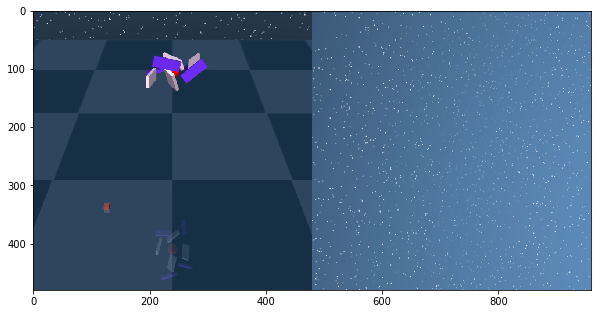

done


In [194]:
from deap import base, creator, gp, tools
from findtarget import FindTarget, Physics

gen = DummyGen()

xml_name = './starfish_world.xml'

with open(xml_name) as starfishf:
    starfish_str = starfishf.read()
    
def capture():
    imnames = set()
    picidx = 0
    _DEFAULT_TIME_LIMIT = 10
    _CONTROL_TIMESTEP = .04
    display_stride = 1 / .04 // 24
    gen.override_from_xml(starfish_str)
    genesis_physics = Physics.from_xml_string(starfish_str, 
                                              common.ASSETS)
    genesis_physics.set_genesis(gen)
    genesis_task = FindTarget()
    genesis_env = control.Environment(genesis_physics, 
                                     genesis_task,
                                     control_timestep=_CONTROL_TIMESTEP,
                                     time_limit=_DEFAULT_TIME_LIMIT)
    action_spec = genesis_env.action_spec()
    observation_spec = genesis_env.observation_spec()
    print(action_spec, observation_spec)
    time_step = genesis_env.reset()
    curtime = 0.0
    top_view = genesis_env.physics.render(480, 480, camera_id='tracking_top')
    side_view = genesis_env.physics.render(480, 480, camera_id='arm_eye')
    plt.figure(figsize=(10,10))
    plt.imshow(np.concatenate((top_view, side_view), axis=1))
    plt.pause(0.5)
    plt.show()
    did_except = False
    
    while(not time_step.last()):
        try:
            action = np.sin(np.linspace(curtime, curtime + 3.14159, num=action_spec.shape[0]))
            time_step = genesis_env.step(action)
            savename = "/tmp/starfish_{0:04}.jpg".format(picidx)
            picidx += 1
            imnames.add(savename)
            curtime += _CONTROL_TIMESTEP
            top_view = genesis_env.physics.render(480, 480, camera_id='tracking_top')
            side_view = genesis_env.physics.render(480, 480, camera_id='arm_eye')
            #plt.imshow(np.concatenate((top_view, side_view), axis=1))
            #plt.pause(0.5)
            io.imsave(savename, np.concatenate((top_view, side_view), axis=1))
        except PhysicsError:
            print('except')
            did_except = True
            break
    if not did_except and os.path.isfile('starfish.mp4'):
        os.remove('starfish.mp4')
    if not did_except:
        !!ffmpeg -f image2 -pattern_type sequence -i "/tmp/starfish_%4d.jpg" -qscale:v 0 starfish.mp4
    for name in imnames:
        os.remove(name)
    print("done")
capture()

In [193]:
starfish_arm = lambda path_so_far, depth: {
    'body': {
        'name': path_so_far + '.' + 'arm_segment' ,
        'pos':  '0.1 0.0 0.0',
        'children': [
            {'joint': {'axis': '1 0 0'}}
        ]
    }
} if depth >= 0 else None

starfish_dict = {
    'body': {'name': 'root', 'childclass': 'starfish', pos: '0 0 1'},
    
}

def dict_2_creature(num_arms, template_xml='starfish.xml'):
    joints = set()
    actuator = set()
    contact_excludes = set()
    
    

NameError: name 'pos' is not defined

In [28]:
def make_starfish_xml_robosumo_format():
    sep = '/'
    
    arm_size = '0.3 0.1 0.015'
    arm_offset = '0.48 0.0 0.0'
    
    tip_size = '0.3 0.05 0.01'
    tip_offset = '0.80 0.0 .0'
    
    geom_type = 'box'
    agentbody = ET.Element('agentbody')
    root = ET.SubElement(agentbody, 'body', childclass='starfish', name='torso', pos='0 0 1.0')
    free_root = ET.SubElement(root, 'joint', damping='0', limited='false', 
                              name='torso' + sep + 'free', type='free')
    torso = ET.SubElement(root, 'geom', name='torso_geom', size='0.05', type='sphere', rgba='1 0 0 1')
    
    arms_def = [{'name': 'left_arm',  'euler':'0.0 0.0 90.0'},
                {'name': 'right_arm', 'euler':'0.0 0.0 -90.0'},
                {'name': 'front_arm', 'euler':'0.0 0.0 180.0'},
                {'name': 'back_arm',  'euler':'0.0 0.0 0.0'}]
    
    joint_default = {'armature':".01", 'damping':".2", 'range':"-30.5 30.5", 'solimplimit':"0 .99 .01", 'stiffness':".6", 'type':"hinge" }
    actuated_joints = []
    contacts = ET.SubElement(agentbody, 'contact')
    actuators = ET.SubElement(agentbody, 'actuator')
    sensors = ET.SubElement(agentbody, 'sensor')
    
    defaults = ET.SubElement(agentbody, 'default')
    geom_defaults = ET.SubElement(defaults, 'geom', conaffinity="1", condim="3", density="5.0", friction="1 0.5 0.5", margin="0.01")
    motor_defaults = ET.SubElement(defaults, 'motor', ctrllimited="true", ctrlrange="-1. 1.")
    
    for arm_def in arms_def:
        arm_name = arm_def['name']
        arm = ET.SubElement(root, 'body', euler=arm_def['euler'], name=arm_name, pos='0 0 0')
        
        arm_rgba = ' '.join([str(float(x) / 255.0) for x in '238 212 240 255'.split(' ')])

        arm_geom = ET.SubElement(arm, 'geom', type=geom_type, pos=arm_offset,
                                 name=arm_name, size=arm_size, rgba=arm_rgba)

        joint_x = ET.SubElement(arm, 'joint', axis='1 0 0', pos="0 0 0",
                                name=arm_name + '_x', **joint_default)
        joint_y = ET.SubElement(arm, 'joint', axis='0 1 0', pos="0 0 0", 
                                name=arm_name + '_y', **joint_default)
        joint_z = ET.SubElement(arm, 'joint', axis='0 0 1', pos="0 0 0",
                                name=arm_name + '_z', **joint_default)
        
        ET.SubElement(sensors, 'jointpos', name='pos_' + arm_name + '_x', joint=arm_name + '_x')
        ET.SubElement(sensors, 'jointpos', name='pos_' + arm_name + '_y', joint=arm_name + '_y')
        ET.SubElement(sensors, 'jointpos', name='pos_' + arm_name + '_z', joint=arm_name + '_z')

        ET.SubElement(sensors, 'jointvel', name='vel_' + arm_name + '_x', joint=arm_name + '_x')
        ET.SubElement(sensors, 'jointvel', name='vel_' + arm_name + '_y', joint=arm_name + '_y')
        ET.SubElement(sensors, 'jointvel', name='vel_' + arm_name + '_z', joint=arm_name + '_z')

        actuated_joints.append(joint_x)
        actuated_joints.append(joint_y)
        actuated_joints.append(joint_y)
        
        ET.SubElement(actuators, 'motor', gear='5', joint=joint_x.attrib['name'], 
                      name=joint_x.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='5', joint=joint_y.attrib['name'],
                      name=joint_y.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='5', joint=joint_z.attrib['name'],
                      name=joint_z.attrib['name'])
                

        exclude = ET.SubElement(contacts, 'exclude', 
                                body1='torso', body2=arm_name)

        tip_name = arm_name + sep + 'tip'
        
        tip = ET.SubElement(arm, 'body', name=tip_name, euler='0.0 0.0 0.0', pos=tip_offset)
        
        tip_rgba = ' '.join([str(float(x) / 255.0) for x in '98 38 218 255'.split(' ')])
        
        tip_geom = ET.SubElement(tip, 'geom', type=geom_type, pos='0.3 0.0 0.0',
                                 name=tip_name, size=tip_size, rgba=tip_rgba)

        tip_joint_x = ET.SubElement(tip, 'joint', axis='1 0 0', name=tip_name + '_x', **joint_default)
        tip_joint_y = ET.SubElement(tip, 'joint', axis='0 1 0', name=tip_name + '_y', **joint_default)
        tip_joint_z = ET.SubElement(tip, 'joint', axis='0 0 1', name=tip_name + '_z', **joint_default)
        
        
        ET.SubElement(sensors, 'jointpos', name='pos_' + tip_name + '_x', joint=tip_name + '_x')
        ET.SubElement(sensors, 'jointpos', name='pos_' + tip_name + '_y', joint=tip_name + '_y')
        ET.SubElement(sensors, 'jointpos', name='pos_' + tip_name + '_z', joint=tip_name + '_z')

        ET.SubElement(sensors, 'jointvel', name='vel_' + tip_name + '_x', joint=tip_name + '_x')
        ET.SubElement(sensors, 'jointvel', name='vel_' + tip_name + '_y', joint=tip_name + '_y')
        ET.SubElement(sensors, 'jointvel', name='vel_' + tip_name + '_z', joint=tip_name + '_z')

        actuated_joints.append(tip_joint_x)
        actuated_joints.append(tip_joint_y)
        actuated_joints.append(tip_joint_z)

        ET.SubElement(actuators, 'motor', gear='5', joint=tip_joint_x.attrib['name'], 
                      name=tip_joint_x.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='5', joint=tip_joint_y.attrib['name'], 
                      name=tip_joint_y.attrib['name'])
        ET.SubElement(actuators, 'motor', gear='5', joint=tip_joint_z.attrib['name'], 
                      name=tip_joint_z.attrib['name'])

        
        exclude = ET.SubElement(contacts, 'exclude', body1=arm_name, body2=tip_name)
        
        if arm_def['name'] == 'front_arm':
            camera = ET.SubElement(tip, 'camera', mode='fixed', 
                                   name='arm_eye', pos='0 0 0.06', euler='180.0 0.0 0.0')
        
    return prettify(agentbody)

xml_str = make_starfish_xml_robosumo_format()
print(xml_str)



<agentbody>
  <body childclass="starfish" name="torso" pos="0 0 1.0">
    <joint damping="0" limited="false" name="torso/free" type="free"/>
    <geom name="torso_geom" rgba="1 0 0 1" size="0.05" type="sphere"/>
    <body euler="0.0 0.0 90.0" name="left_arm" pos="0 0 0">
      <geom name="left_arm" pos="0.48 0.0 0.0" rgba="0.9333333333333333 0.8313725490196079 0.9411764705882353 1.0" size="0.3 0.1 0.015" type="box"/>
      <joint armature=".01" axis="1 0 0" damping=".2" name="left_arm_x" pos="0 0 0" range="-30.5 30.5" solimplimit="0 .99 .01" stiffness=".6" type="hinge"/>
      <joint armature=".01" axis="0 1 0" damping=".2" name="left_arm_y" pos="0 0 0" range="-30.5 30.5" solimplimit="0 .99 .01" stiffness=".6" type="hinge"/>
      <joint armature=".01" axis="0 0 1" damping=".2" name="left_arm_z" pos="0 0 0" range="-30.5 30.5" solimplimit="0 .99 .01" stiffness=".6" type="hinge"/>
      <body euler="0.0 0.0 0.0" name="left_arm/tip" pos="0.80 0.0 .0">
        <geom name="left_arm/tip" po